<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li></ul></div>

In [18]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
plt.style.use('gadfly')
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
os.environ["PROJ_LIB"] = "C:\\Users\\ricca\\Anaconda3\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap

In [2]:
data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# EDA

In [3]:
df.shape

(20640, 9)

In [4]:
def cols_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_%'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    return pd.DataFrame(eda_df)

In [5]:
cols_eda(df)

,count,dtypes,max,mean,median,min,null_%,null_sum
MedInc,20640,float64,15.000100,3.870671,3.534800,0.499900,0.0,0
HouseAge,20640,float64,52.000000,28.639486,29.000000,1.000000,0.0,0
AveRooms,20640,float64,141.909091,5.429000,5.229129,0.846154,0.0,0
AveBedrms,20640,float64,34.066667,1.096675,1.048780,0.333333,0.0,0
Population,20640,float64,35682.000000,1425.476744,1166.000000,3.000000,0.0,0
AveOccup,20640,float64,1243.333333,3.070655,2.818116,0.692308,0.0,0
Latitude,20640,float64,41.950000,35.631861,34.260000,32.540000,0.0,0
Longitude,20640,float64,-114.310000,-119.569704,-118.490000,-124.350000,0.0,0
target,20640,float64,5.000010,2.068558,1.797000,0.149990,0.0,0


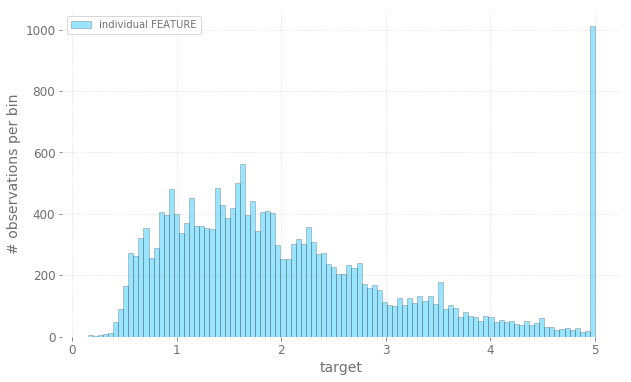

In [6]:
plt.figure(figsize=(10,6))
sns.distplot(df.target, kde=False, bins=100, hist_kws={'edgecolor':'k', 'linewidth':.5}, label='individual FEATURE')
plt.xlabel('target')
plt.ylabel('# observations per bin')
plt.legend(loc='best');

there is an outliar, it might originate from wrong data.

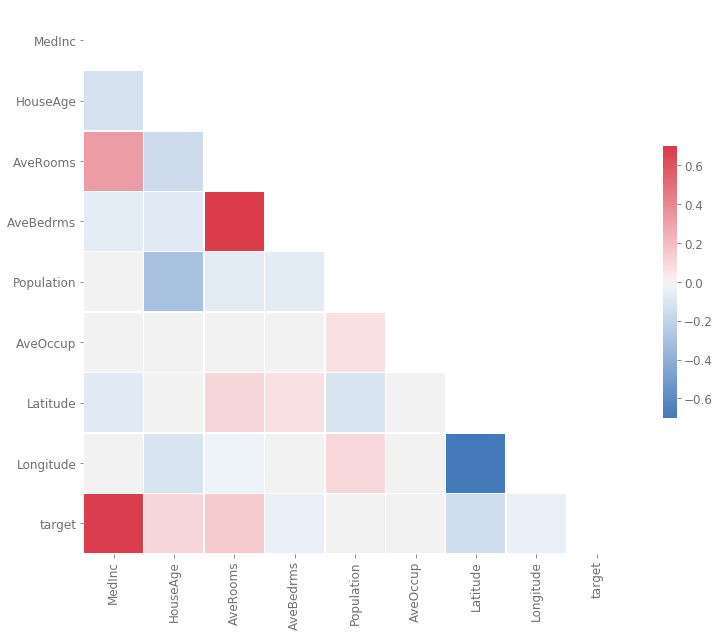

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # mask to have just a triangular matrix
f, ax = plt.subplots(figsize=(13, 10))
cmap = sns.diverging_palette(250, 9, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.7, vmax=0.7, center=0,
            square=True, annot=False, linewidths=.5, cbar_kws={"shrink": .5});

<Figure size 432x288 with 0 Axes>

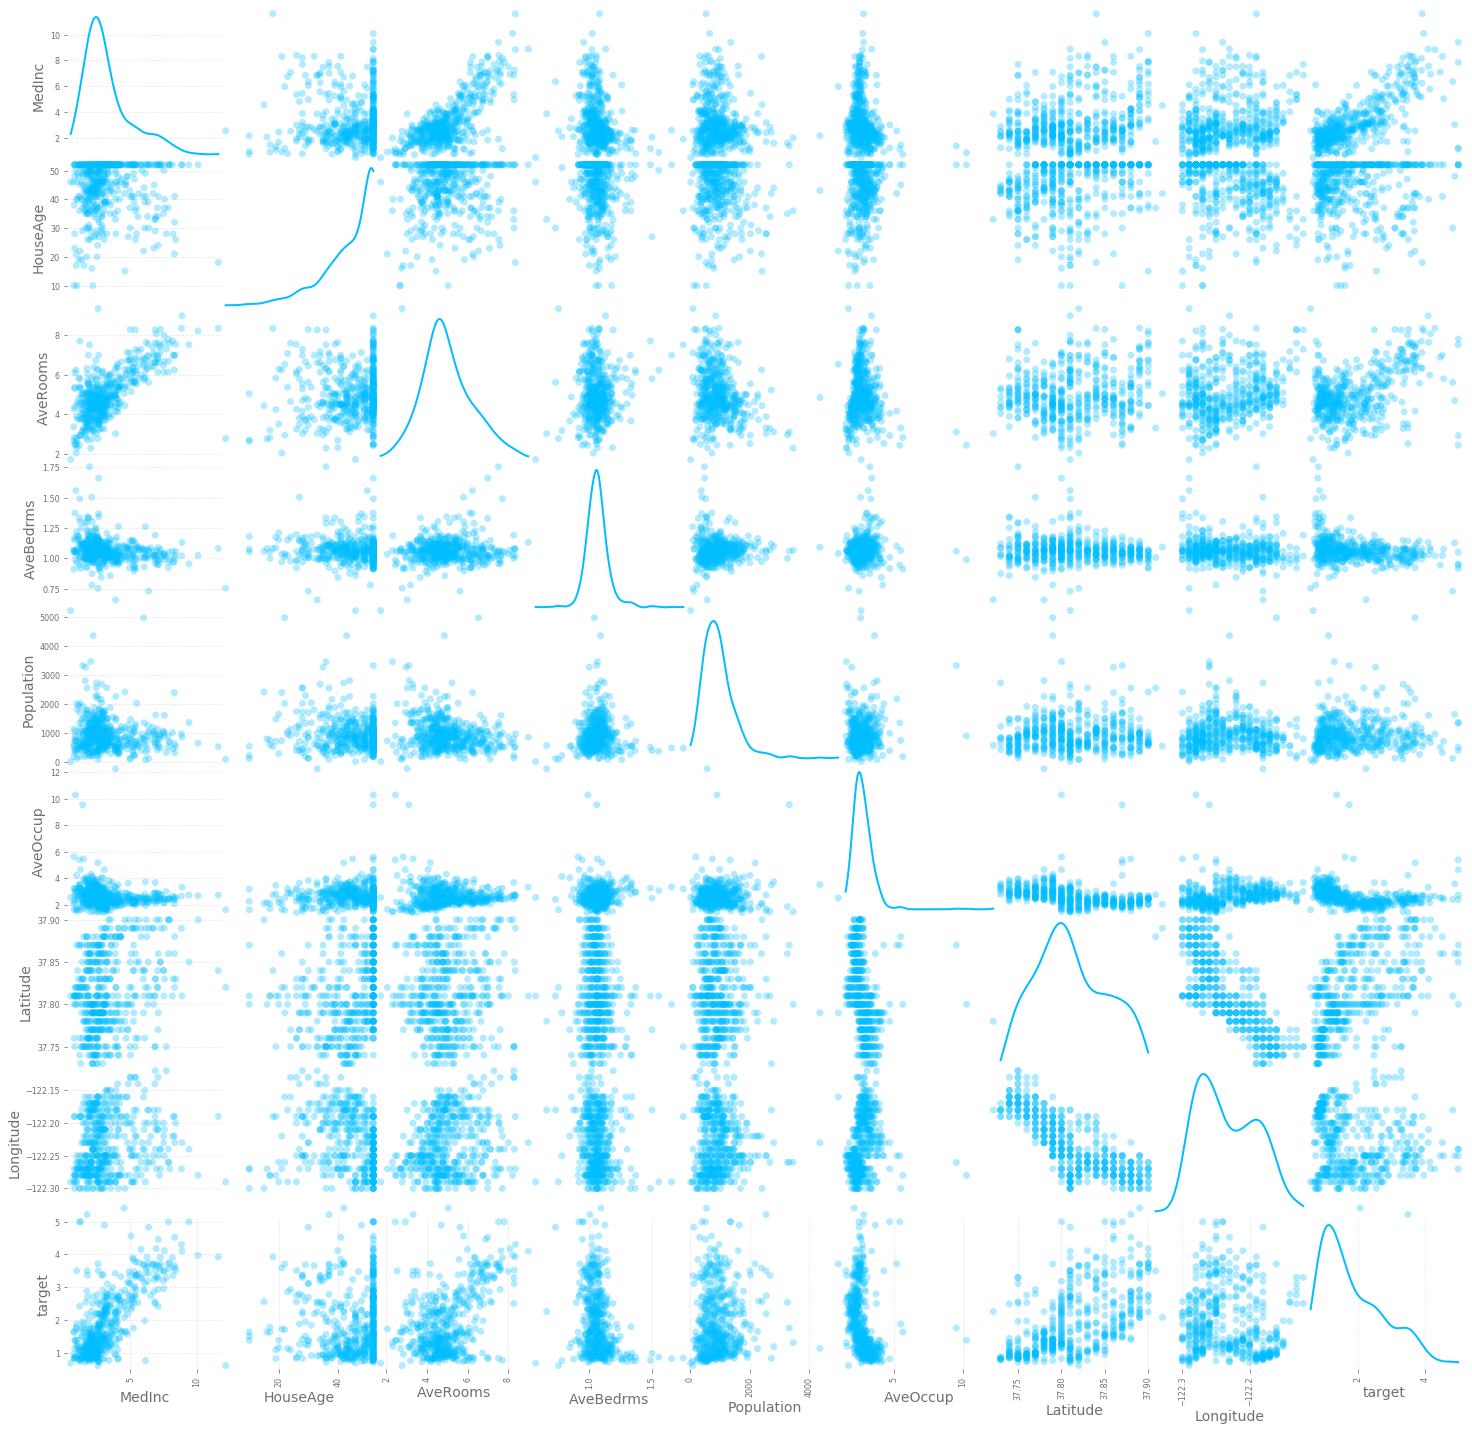

In [8]:
#display scatter_matrix also
fig = plt.figure()
scatter_matrix(df[:500], figsize=(25,25), alpha=0.3, diagonal="kde", marker="o");

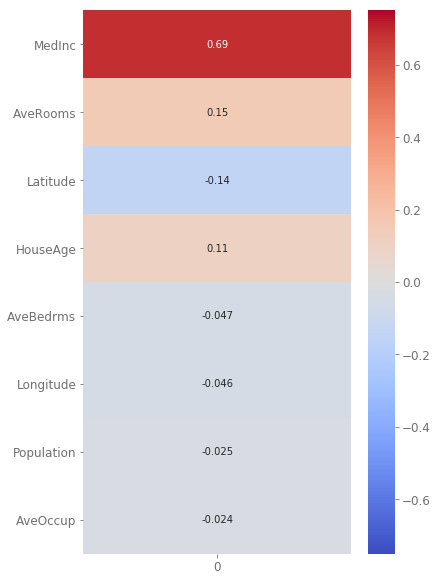

In [9]:
correlations = df.corrwith(df['target']).iloc[:-1].to_frame() # you should have features only and label as last column in df
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(6,10))
sns.heatmap(sorted_correlations.to_frame(), cmap='coolwarm', annot=True, vmin=-0.75, vmax=0.75, ax=ax);

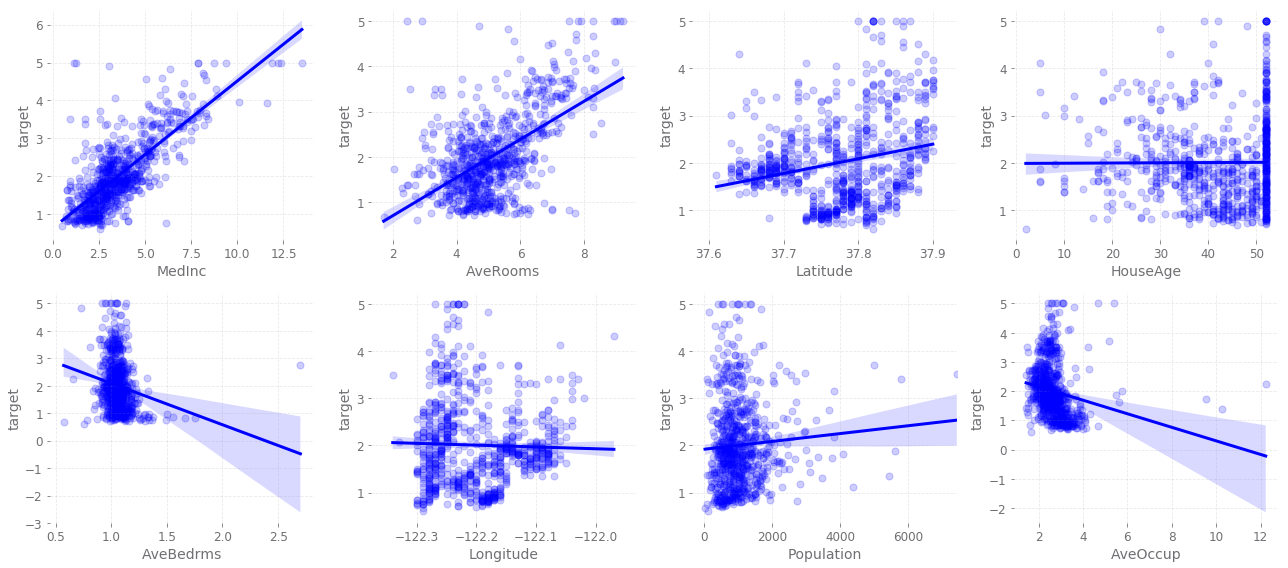

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8)) # this is for 9 plots
for i, col in enumerate(sorted_correlations.index[:8]):
    sns.regplot(x=col, y='target', data=df[:800], fit_reg=True, color='blue', scatter_kws={'alpha':0.2}, ax=axes[i//4][i%4])
plt.tight_layout()

In [11]:
BBox = (df.Longitude.min(), df.Longitude.max(), df.Latitude.min(), df.Latitude.max())
BBox

(-124.35, -114.31, 32.54, 41.95)

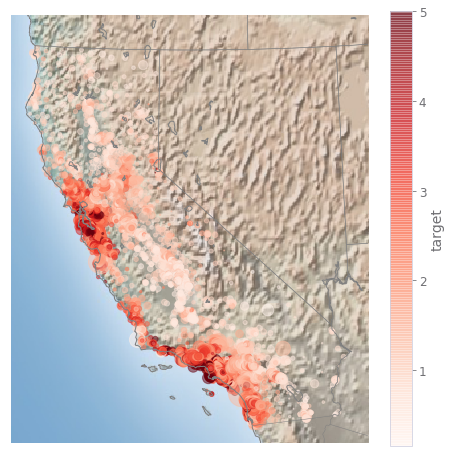

In [12]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(df['Longitude'].values, df['Latitude'].values, latlon=True,
          c=df['target'].values, s=df['Population'].values/50,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label='target');
# plt.clim(3, 7)

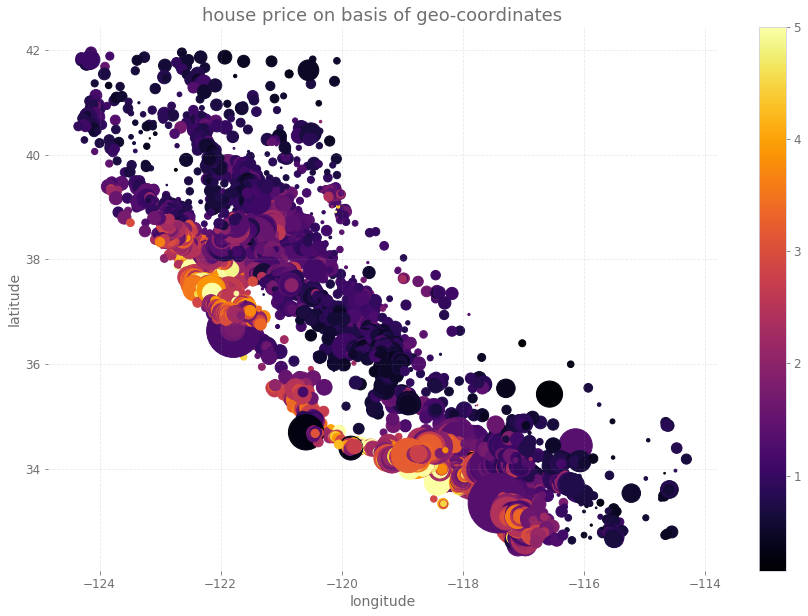

In [13]:
plt.figure(figsize=(15,10))
plt.scatter(df['Longitude'],df['Latitude'],c=df['target'],s=df['Population']/10, cmap='inferno')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('house price on basis of geo-coordinates')
plt.show()

# Model

In [14]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print(f'The RMSE is: {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'The target mean value is: {np.mean(df.target.values)}')
print(f'Therefore the error is about {np.sqrt(mean_squared_error(y_test,y_pred))*100/np.mean(df.target.values)} %')
print(f'The R2 value is: {forest.score(X_test, y_test)}')

The RMSE is: 0.505760422142145
The target mean value is: 2.068558169089147
Therefore the error is about 24.44990088747892 %
The R2 value is: 0.8047986477101373


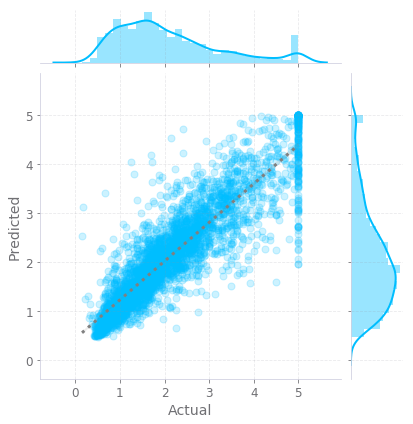

In [16]:
test_res = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})

sns.jointplot(x='Actual', y='Predicted', data=test_res,
              joint_kws={'scatter_kws':{'alpha':0.2},'line_kws':{'color':'gray', 'linestyle':'dotted'}}, kind="reg");

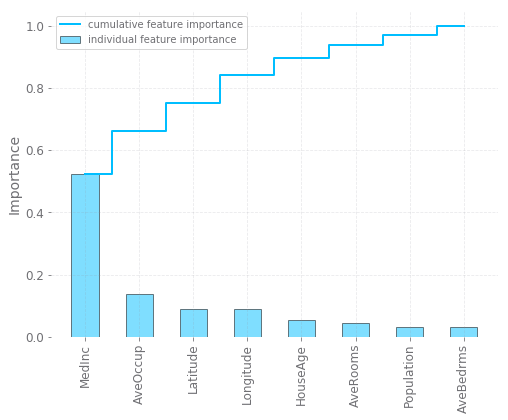

In [17]:
def plot_feature_importance(df, forest, n):
    features = df.columns
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    fig = plt.figure(figsize=(8,6))
    plt.bar(np.arange(0,n,1), importances[indices[:n]], align='center', width=.5, alpha=.5, linewidth=1.0, edgecolor='k',
           label='individual feature importance')
    plt.step(np.arange(0,n,1), np.cumsum(importances[indices[:n]]), where='mid', label='cumulative feature importance')
    plt.xticks(np.arange(0,n,1), features[indices[:n]], rotation=90)
    plt.ylabel('Importance')
    plt.legend(loc='best')
    
plot_feature_importance(X_train, forest, X_train.shape[1])